# Coursera Capstone Project

The code for the coursera capstone project.

### Importing Required Library

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import csv

The data of neighbourhood of Kathmandu is scrapped using "Beautiful" from
"https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Kathmandu".

Latitude and longitude are added by using Google Maps Geocoding API.

In [6]:
df = pd.read_csv('ktm.csv') # And that csv file is opened and read

In [7]:
df.shape


(13, 3)

In [8]:
df

,Neighbourhood,Latitude,Longitude
0,Baluwatar,27.7291,85.3286
1,Baneshwor,27.6915,85.3420
2,Chabahil,27.7166,85.3485
3,Dilli,27.7071,85.3278
4,Gairidhara,27.7191,85.3262
5,Gyaneshwar,27.7102,85.3330
6,Kalimati,27.7000,85.2891
7,Lazimpat,27.7215,85.3201
8,Maru,27.7052,85.3036
9,Naxal,27.7159,85.3278


## Importing other Libraries

In [56]:
import folium # Map plotting library
import numpy as np
from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering stage
from sklearn.cluster import KMeans

%matplotlib inline

## FourSquare API Credentials


In [13]:
CLIENT_ID = 'RLTKJS2UFVSTBCUQBBB4FASHY2A0YFTH5TBBMR03FCQ2THLV' # your Foursquare ID
CLIENT_SECRET = '1NOCRO4CAYGRDJSXPZ3HXYLIZTELNM2TT1QTYV5TD4L5QJWJ' # your Foursquare Secret
ACCESS_TOKEN = '5ZKC3T5R343SLJCFH42ZC5YGTCILV34LRXKO22SMNGQZ2KXZ' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RLTKJS2UFVSTBCUQBBB4FASHY2A0YFTH5TBBMR03FCQ2THLV
CLIENT_SECRET:1NOCRO4CAYGRDJSXPZ3HXYLIZTELNM2TT1QTYV5TD4L5QJWJ


## Creating a folium map of Kathmandu

In [57]:
# kathmandu latitude and longitude using Google search
ktm_lat = 27.7172
ktm_lng = 85.3240

# Creates map of Kathmandu using latitude and longitude values
map_ktm = folium.Map(location=[ktm_lat, ktm_lng], zoom_start=12)

# Add markers to map
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ktm)  
    
map_ktm

## Defining own function to get the name of the category

In [20]:
# Gets the name of the category

def get_category_type(row):
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Using the FourSquare API on all neighbourhoods

In [32]:
explore_df_list = []

for i, nbd_name in enumerate(df['Neighbourhood']):  
    
    try :
        ### Getting the data of neighbourhood
        nbd_name = df.loc[i, 'Neighbourhood']
        nbd_lat = df.loc[i, 'Latitude']
        nbd_lng = df.loc[i, 'Longitude']

        radius = 1000 # Setting the radius as 1000 metres
        LIMIT = 30 # Getting the top 30 venues

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={} \
        &client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, nbd_lat, nbd_lng, VERSION, radius, LIMIT)
        #url = 'https://api.foursquare.com/v2/venues/explore?client_id={} &client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)


        results = json.loads(requests.get(url).text)
        results = results['response']['groups'][0]['items']

        nearby = json_normalize(results) # Flattens JSON

        # Filtering the columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]

        # Renaming the columns
        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns

        # Gets the categories
        nearby['Category'] = nearby.apply(get_category_type, axis=1)    

        # Gets the data required
        for i, name in enumerate(nearby['Name']):
            s_list = nearby.loc[i, :].values.tolist()  # Converts the numpy array to a python list
            f_list = [nbd_name, nbd_lat, nbd_lng] + s_list
            explore_df_list.append(f_list)
    
    except Exception as e:
        pass

<ipython-input-32-889bf067cad6>:23: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby = json_normalize(results) # Flattens JSON


## Creating a dataframe for performing clustering operations

In [33]:
explore_df = pd.DataFrame([item for item in explore_df_list])
explore_df.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Name', 'Venue Category', 'Venue Latitude', 'Venue Longitude']
explore_df.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,Baluwatar,27.7291,85.3286,Kotetsu,Japanese Restaurant,27.728582,85.324968
1,Baluwatar,27.7291,85.3286,European Bakery,Bakery,27.727959,85.334280
2,Baluwatar,27.7291,85.3286,Midori Cafe,Café,27.724202,85.331448
3,Baluwatar,27.7291,85.3286,Momo Magic,Asian Restaurant,27.735293,85.331650
4,Baluwatar,27.7291,85.3286,Saigon Pho,Vietnamese Restaurant,27.725432,85.322886


In [34]:
explore_df.shape


(227, 7)

## Performing one-hot encoding to analyze neighbourhoods

In [35]:
# One hot encoding
ktm_onehot = pd.get_dummies(explore_df[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
ktm_onehot['Neighbourhood'] = explore_df['Neighbourhood'] 

# Move neighborhood column to the first column
fixed_columns = [ktm_onehot.columns[-1]] + ktm_onehot.columns[:-1].values.tolist()
ktm_onehot = ktm_onehot[fixed_columns]

ktm_onehot.head()

,Neighbourhood,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,...,Restaurant,Road,Rock Club,Shopping Mall,Soccer Field,Spa,Steakhouse,Tea Room,Theme Park Ride / Attraction,Vietnamese Restaurant
0,Baluwatar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Baluwatar,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Baluwatar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Baluwatar,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Baluwatar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Aggregating venues by neighbourhoods

In [36]:
ktm_grouped = ktm_onehot.groupby('Neighbourhood').mean().reset_index()
ktm_grouped.head()

,Neighbourhood,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,...,Restaurant,Road,Rock Club,Shopping Mall,Soccer Field,Spa,Steakhouse,Tea Room,Theme Park Ride / Attraction,Vietnamese Restaurant
0,Baluwatar,0.0,0.0,0.0,0.0,0.000000,0.0,0.217391,0.0,0.043478,...,0.086957,0.0,0.0,0.00,0.043478,0.043478,0.0,0.0,0.000000,0.043478
1,Baneshwor,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.285714,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,Chabahil,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.125000,0.0,0.0,0.25,0.000000,0.125000,0.0,0.0,0.000000,0.000000
3,Dilli,0.0,0.0,0.0,0.0,0.058824,0.0,0.000000,0.0,0.000000,...,0.058824,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.058824,0.000000
4,Gairidhara,0.0,0.0,0.0,0.0,0.033333,0.0,0.133333,0.0,0.000000,...,0.133333,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.033333


## Creating a function to return the most common venues

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Creating a new dataframe to get the top 10 venues

In [40]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = ktm_grouped['Neighbourhood']

for ind in np.arange(ktm_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ktm_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Baluwatar,Asian Restaurant,Café,Restaurant,French Restaurant,Diner,Coffee Shop,Breakfast Spot,Indian Restaurant,Bakery,Vietnamese Restaurant
1,Baneshwor,Fast Food Restaurant,Restaurant,Bistro,Playground,Café,Vietnamese Restaurant,Coffee Shop,Garden,Fried Chicken Joint,French Restaurant
2,Chabahil,Shopping Mall,Italian Restaurant,Historic Site,Multiplex,Spa,Restaurant,French Restaurant,Food,Fast Food Restaurant,Electronics Store
3,Dilli,Lake,Multiplex,Café,Outdoors & Recreation,Coffee Shop,Bus Station,Department Store,Dumpling Restaurant,Restaurant,Hotel
4,Gairidhara,Café,Hotel,Asian Restaurant,Restaurant,Vietnamese Restaurant,Himalayan Restaurant,Food,Hotel Bar,Ice Cream Shop,Jazz Club


## Setting the dataframe for k-means clustering to operate on

In [41]:
ktm_grouped_clustering = ktm_grouped.drop('Neighbourhood', 1)


## Using K-means clustering

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [43]:
max_range = 13 # Maximum range of clusters


In [44]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kgc = ktm_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kgc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kgc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

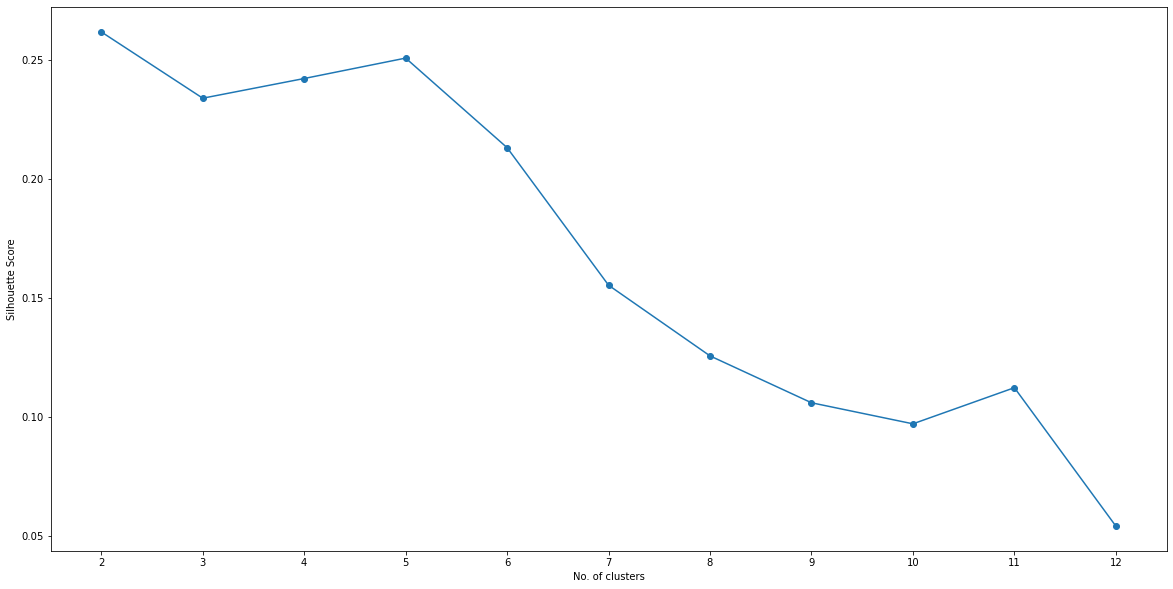

In [45]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")


### From the graph the optimal number is found out to be considered for our clustering


In [46]:
opt = np.argmax(scores) + 2 # Finds the optimal value
opt

2

## K-Means clustering for the optimal number of clusters

In [47]:
kclusters = opt

# Run k-means clustering
kgc = ktm_grouped_clustering
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit(kgc)

In [48]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

## Creating a dataframe containing the necessary data

In [49]:
ktm_merged = df
ktm_merged = ktm_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
ktm_merged.dropna(inplace = True)
ktm_merged['Cluster Labels'] = ktm_merged['Cluster Labels'].astype(int)
ktm_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Baluwatar,27.7291,85.3286,1,Asian Restaurant,Café,Restaurant,French Restaurant,Diner,Coffee Shop,Breakfast Spot,Indian Restaurant,Bakery,Vietnamese Restaurant
1,Baneshwor,27.6915,85.3420,0,Fast Food Restaurant,Restaurant,Bistro,Playground,Café,Vietnamese Restaurant,Coffee Shop,Garden,Fried Chicken Joint,French Restaurant
2,Chabahil,27.7166,85.3485,1,Shopping Mall,Italian Restaurant,Historic Site,Multiplex,Spa,Restaurant,French Restaurant,Food,Fast Food Restaurant,Electronics Store
3,Dilli,27.7071,85.3278,1,Lake,Multiplex,Café,Outdoors & Recreation,Coffee Shop,Bus Station,Department Store,Dumpling Restaurant,Restaurant,Hotel
4,Gairidhara,27.7191,85.3262,1,Café,Hotel,Asian Restaurant,Restaurant,Vietnamese Restaurant,Himalayan Restaurant,Food,Hotel Bar,Ice Cream Shop,Jazz Club


In [50]:
ktm_merged

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Baluwatar,27.7291,85.3286,1,Asian Restaurant,Café,Restaurant,French Restaurant,Diner,Coffee Shop,Breakfast Spot,Indian Restaurant,Bakery,Vietnamese Restaurant
1,Baneshwor,27.6915,85.3420,0,Fast Food Restaurant,Restaurant,Bistro,Playground,Café,Vietnamese Restaurant,Coffee Shop,Garden,Fried Chicken Joint,French Restaurant
2,Chabahil,27.7166,85.3485,1,Shopping Mall,Italian Restaurant,Historic Site,Multiplex,Spa,Restaurant,French Restaurant,Food,Fast Food Restaurant,Electronics Store
3,Dilli,27.7071,85.3278,1,Lake,Multiplex,Café,Outdoors & Recreation,Coffee Shop,Bus Station,Department Store,Dumpling Restaurant,Restaurant,Hotel
4,Gairidhara,27.7191,85.3262,1,Café,Hotel,Asian Restaurant,Restaurant,Vietnamese Restaurant,Himalayan Restaurant,Food,Hotel Bar,Ice Cream Shop,Jazz Club
5,Gyaneshwar,27.7102,85.3330,1,Asian Restaurant,American Restaurant,Historic Site,Multiplex,Fried Chicken Joint,Dumpling Restaurant,Lake,Café,Department Store,Outdoors & Recreation
6,Kalimati,27.7000,85.2891,1,Hotel,Tea Room,Indian Restaurant,Italian Restaurant,Bus Station,Vietnamese Restaurant,Department Store,Fried Chicken Joint,French Restaurant,Food
7,Lazimpat,27.7215,85.3201,1,Hotel,Restaurant,Asian Restaurant,Hostel,Café,Vietnamese Restaurant,Multiplex,French Restaurant,Garden,Himalayan Restaurant
8,Maru,27.7052,85.3036,1,Restaurant,Café,Asian Restaurant,Historic Site,Coffee Shop,Hotel,Electronics Store,Eastern European Restaurant,Plaza,Himalayan Restaurant
9,Naxal,27.7159,85.3278,1,Café,Hotel,Asian Restaurant,Restaurant,Multiplex,American Restaurant,Coffee Shop,Outdoors & Recreation,Himalayan Restaurant,Ice Cream Shop


## Visualizing the clusters

In [58]:
# Create map
map_clusters = folium.Map(location=[ktm_lat, ktm_lng], zoom_start=12)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ktm_merged['Latitude'], ktm_merged['Longitude'], ktm_merged['Neighbourhood'], ktm_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    map_clusters.add_child(
        folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

In [54]:
val = 2
ktm_merged.loc[ktm_merged['Cluster Labels'] == (val - 1), ktm_merged.columns[[0] + np.arange(4, ktm_merged.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Baluwatar,Asian Restaurant,Café,Restaurant,French Restaurant,Diner,Coffee Shop,Breakfast Spot,Indian Restaurant,Bakery,Vietnamese Restaurant
2,Chabahil,Shopping Mall,Italian Restaurant,Historic Site,Multiplex,Spa,Restaurant,French Restaurant,Food,Fast Food Restaurant,Electronics Store
3,Dilli,Lake,Multiplex,Café,Outdoors & Recreation,Coffee Shop,Bus Station,Department Store,Dumpling Restaurant,Restaurant,Hotel
4,Gairidhara,Café,Hotel,Asian Restaurant,Restaurant,Vietnamese Restaurant,Himalayan Restaurant,Food,Hotel Bar,Ice Cream Shop,Jazz Club
5,Gyaneshwar,Asian Restaurant,American Restaurant,Historic Site,Multiplex,Fried Chicken Joint,Dumpling Restaurant,Lake,Café,Department Store,Outdoors & Recreation
6,Kalimati,Hotel,Tea Room,Indian Restaurant,Italian Restaurant,Bus Station,Vietnamese Restaurant,Department Store,Fried Chicken Joint,French Restaurant,Food
7,Lazimpat,Hotel,Restaurant,Asian Restaurant,Hostel,Café,Vietnamese Restaurant,Multiplex,French Restaurant,Garden,Himalayan Restaurant
8,Maru,Restaurant,Café,Asian Restaurant,Historic Site,Coffee Shop,Hotel,Electronics Store,Eastern European Restaurant,Plaza,Himalayan Restaurant
9,Naxal,Café,Hotel,Asian Restaurant,Restaurant,Multiplex,American Restaurant,Coffee Shop,Outdoors & Recreation,Himalayan Restaurant,Ice Cream Shop
10,Samakhushi,Hotel,Asian Restaurant,Restaurant,Vietnamese Restaurant,Pizza Place,Hostel,Hotel Bar,Indian Restaurant,Japanese Restaurant,Jazz Club


###                       thank you 